<a href="https://colab.research.google.com/github/Zakrung23/DLS/blob/main/hw_language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [30]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [31]:
!pip install -q datasets

Импорт необходимых библиотек

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [33]:
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [35]:
# Загрузим датасет
dataset = load_dataset('imdb')

In [36]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [37]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences

In [38]:
for sentence in tqdm(dataset['train']['text']):
  sentences.extend([x.lower() for x in sent_tokenize(sentence) if len(x) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [39]:
print("Всего предложений:", len(sentences))

Всего предложений: 28827


Посчитаем для каждого слова его встречаемость.

In [40]:
words = Counter()

for sentence in tqdm(sentences):
  for word in word_tokenize(sentence):
    words[word]+=1

# Расчет встречаемости слов

words

  0%|          | 0/28827 [00:00<?, ?it/s]

Counter({'2/10': 35,
         '.': 18593,
         'even': 210,
         'the': 3227,
         'sound': 43,
         'is': 3217,
         'bad': 584,
         '!': 6816,
         'filmmakers': 2,
         '?': 3781,
         'they': 506,
         'looked': 19,
         'quite': 72,
         'wonderful': 68,
         'but': 674,
         'that': 1228,
         'was': 1620,
         'it': 4088,
         'its': 138,
         'not': 1098,
         'cast': 77,
         'setting': 7,
         'there': 389,
         'none': 55,
         'please': 106,
         'do': 848,
         "n't": 1233,
         'watch': 223,
         'he': 735,
         'just': 639,
         'too': 280,
         'pathetic': 30,
         'here': 188,
         'so': 639,
         'i': 3109,
         'am': 102,
         'in': 632,
         'disbelief': 1,
         'and': 1255,
         'then': 180,
         'this': 2286,
         'total': 44,
         'crap': 71,
         '<': 980,
         'br': 974,
         '/': 983,
 

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [41]:
vocab = set(['<unk>','<bos>','<eos>','<pad>'])
vocab_size = 9000

for word,cnt in words.most_common(vocab_size):
  vocab.add(word)
# Наполнение словаря

In [42]:
len(vocab)

9004

In [43]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [44]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 9004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [45]:
vocab_list = sorted(list(vocab))
word2ind = {word: i for i, word in enumerate(vocab_list)}
ind2word = {i: char for char, i in word2ind.items()}

In [46]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        sentence = self.data[idx]
        words_in_sentence = word_tokenize(sentence)
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in words_in_sentence]
        tokenized_sentence += [self.eos_id]
        # Допишите код здесь

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [47]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [48]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [49]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader,desc='validating'):
            logits = model(batch['input_ids']).flatten(start_dim=0,end_dim=1)# Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [50]:
def train_model(model, criterion, optimizer, dataloader, n_epochs) -> float:
    # Напишите код здесь
    losses = []
    perplexity = []
    for epoch in range(n_epochs):
      model.train()
      losses_per_epoch = []
      perplexity_per_epoch = []
      for batch in tqdm(dataloader,desc=f'Training epoch {epoch}'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0,end_dim=1)
        loss = criterion(
            logits,batch['target_ids'].flatten()
        )
        loss.backward()
        optimizer.step()

        losses_per_epoch.append(loss.item())

      losses.append(sum(losses_per_epoch)/len(losses_per_epoch))
      perplexity.append(evaluate(model,criterion,dataloader))

    return losses,perplexity

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [51]:
class LanguageModel(nn.Module):
    def __init__(self,vocab_size:int, hidden_dim:int, num_layers:int, dropout:int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,hidden_dim)
        self.rnn = nn.LSTM(hidden_dim,hidden_dim,batch_first=True,num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim,hidden_dim)
        self.projection = nn.Linear(hidden_dim,vocab_size)

        self.nonlin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)
        output,_ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.nonlin(output)))
        projection = self.projection(self.nonlin(output))

        return projection


class LanguageModel_GRU_with_layernorm(nn.Module):
    def __init__(self,vocab_size:int, hidden_dim:int, num_layers:int, dropout:int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,hidden_dim)
        self.rnn = nn.GRU(hidden_dim,hidden_dim,batch_first=True,num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim,hidden_dim)
        self.projection = nn.Linear(hidden_dim,vocab_size)

        self.nonlin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)
        self.layernorm = nn.LayerNorm(hidden_dim)
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.layernorm(self.embedding(input_batch))
        output,_ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.nonlin(output)))
        projection = self.projection(self.nonlin(output))

        return projection

In [52]:
num_layers = {
    'first_exp':3,
    'second_exp':4
}

dropout = {
    'first_exp':0.1,
    'second_exp':0.1
}



In [53]:
model = {'first_exp': LanguageModel(len(word2ind),
                                     hidden_dim=256,
                                     num_layers=num_layers['first_exp'],
                                     dropout = dropout['first_exp']).to(device),
           'second_exp':LanguageModel_GRU_with_layernorm(len(word2ind),
                                      hidden_dim=512,
                                      num_layers=num_layers['second_exp'],
                                      dropout = dropout['second_exp']).to(device)
           }
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = {'first_exp':torch.optim.Adam(model['first_exp'].parameters()),
               'second_exp':torch.optim.AdamW(model['second_exp'].parameters())}

In [67]:
losses_1,perplexity_1 = train_model(model['first_exp'], criterion, optimizer['first_exp'],train_dataloader,n_epochs=100)

Training epoch 0:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [55]:
losses_2,perplexity_2 = train_model(model['second_exp'], criterion, optimizer['second_exp'],train_dataloader,n_epochs=10)

Training epoch 0:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/181 [00:00<?, ?it/s]

validating:   0%|          | 0/181 [00:00<?, ?it/s]

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

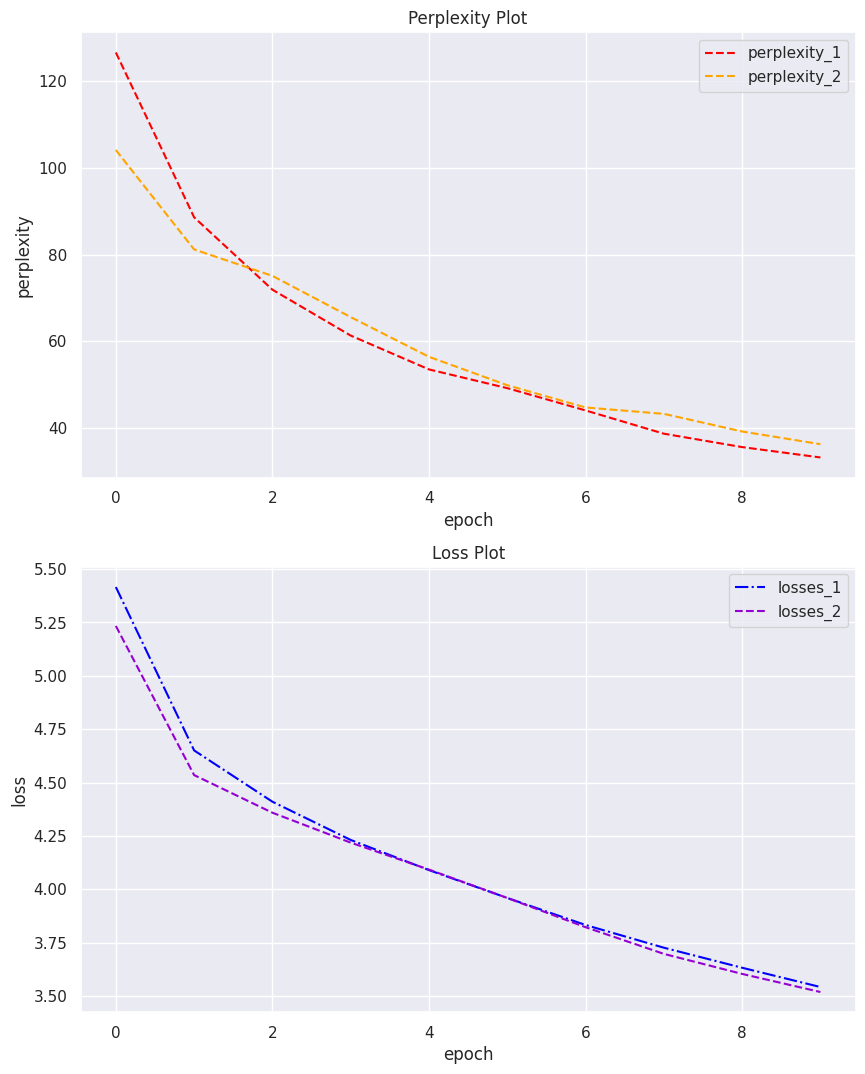

In [68]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(perplexity_1,label='perplexity_1',c='red',linestyle='--')
ax[0].plot(perplexity_2,label='perplexity_2',c='orange',linestyle='--')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('perplexity')
ax[0].set_title('Perplexity Plot')
ax[0].legend()

ax[1].plot(losses_1,label='losses_1',c='blue',linestyle='-.')
ax[1].plot(losses_2,label='losses_2',c='darkviolet',linestyle='--')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].set_title('Loss Plot')
ax[1].legend()

plt.subplots_adjust(bottom=-0.1)
plt.show()

In [123]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 256 ) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break

    words = ''.join([ind2word[idx.item()]+ ' ' for idx in input_ids])

    return words

In [127]:
generate_sequence(model=model['first_exp'],starting_seq = 'i was')

'<bos> i was wrong . <eos> '